In [2]:
import pandas as pd
import numpy as np

### Mapillary counts

In [3]:
img_ct = pd.read_csv("/Users/alexandra/Documents/GitHub/dataset_creation/data/tag_counts/germany_image_counts.csv")

In [4]:
img_ct.image_count.sum()

169994544

about 170M images in Germany (query data Nov. 2023)

In [5]:
meta = pd.read_csv("/Users/alexandra/Documents/GitHub/dataset_creation/data/v5/train_tiles_metadata.csv")

In [6]:
len(meta) / img_ct.image_count.sum()

0.3026986736703738

30% sample

In [7]:
meta["date"] = pd.to_datetime(meta.captured_at,  unit="ms")

In [8]:
meta["year"] = pd.to_datetime(meta.captured_at,  unit="ms").dt.year

In [9]:
meta.value_counts("year").sort_index()

year
1899           9
1921           4
1970          96
1980         459
1994          18
2000           2
2002        1299
2004          48
2005           5
2006         849
2007         320
2008        1405
2009        2129
2010        3010
2011        7734
2012       11964
2013        9228
2014      620403
2015     1203190
2016     2040851
2017     2915628
2018     3688915
2019     5432688
2020     8348287
2021    10028970
2022     8821842
2023     8060625
2024      257145
Name: count, dtype: int64

In [10]:
meta.head()

,tile_id,id,sequence_id,captured_at,compass_angle,is_pano,creator_id,lon,lat,date,year
0,8472_5495_14,1707356142945280,NFZVQseCHAkdM93c8TBX2p,1646408953313,235.849106,False,104536648714052,6.163904,50.854445,2022-03-04 15:49:13.313,2022
1,8472_5495_14,237587568154199,fnSJ7GaGLWXTQciojBhBOw,1441019869000,330.000000,False,103390745232765,6.165894,50.860008,2015-08-31 11:17:49.000,2015
2,8472_5495_14,975748309981229,NFZVQseCHAkdM93c8TBX2p,1646408904312,230.319958,False,104536648714052,6.166087,50.855450,2022-03-04 15:48:24.312,2022
3,8472_5495_14,168724596206843,TuRPvl8KZ0JDIYLEoFwbr4,1694435326000,143.651000,False,103550301888099,6.165631,50.854021,2023-09-11 12:28:46.000,2023
4,8472_5495_14,495587888161346,JEn6aNGUCtcuSafGMlEncw,1564562164000,179.258416,False,103390745232765,6.171484,50.850364,2019-07-31 08:36:04.000,2019


In [11]:
# take out date outliers (any dates before launch date 2013)
meta[meta["captured_at"] > 1363074956000]["date"].describe()

count                         51427459
mean     2020-10-04 19:29:34.389486848
min                2013-03-16 13:35:26
25%                2019-06-23 16:25:13
50%      2021-03-17 12:41:47.158000128
75%         2022-06-12 10:46:37.500000
max                2024-01-16 16:12:56
Name: date, dtype: object

In [12]:
np.percentile(meta[meta["captured_at"] > 1363074956000]["date"], 50)

KeyboardInterrupt: 

<Axes: >

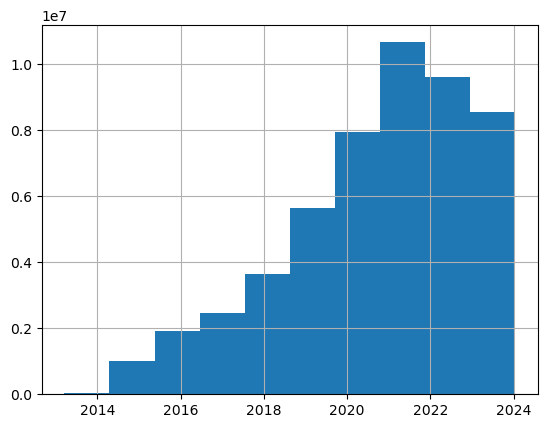

In [ ]:
meta[meta["captured_at"] > 1363074956000]["date"].hist()

In [ ]:
meta["date"].describe()

count                         51457123
mean     2020-10-02 15:08:45.973085440
min                1899-11-30 08:09:47
25%         2019-06-23 11:53:59.476000
50%                2021-03-15 08:50:17
75%                2022-06-12 05:47:11
max                2024-01-16 16:12:56
Name: date, dtype: object

### OSM counts

In [ ]:
osm_data = pd.read_csv('/Users/alexandra/Nextcloud-HTW/SHARED/SurfaceAI/data/OSM/osm_surface_tag_counts_germany.csv')

In [ ]:
osm_sum = osm_data["ct"].sum()

osm_data["percentage"] = osm_data["ct"] / osm_sum * 100

In [ ]:
osm_data

,ct,surface,percentage
0,3320158,asphalt,46.877943
1,1064144,paving_stones,15.024852
2,433195,ground,6.116363
3,374243,gravel,5.284008
4,363550,grass,5.133032
5,328231,paved,4.634356
6,266713,compacted,3.765772
7,148819,concrete,2.101204
8,145985,dirt,2.061190
9,135753,sett,1.916722


In [ ]:
osm_data["surface_clean"] = osm_data["surface"].replace(
        [
            "compacted",
            "gravel",
            "ground",
            "fine_gravel",
            "dirt",
            "grass",
            "earth",
            "sand",
        ],
        "unpaved",
    )

osm_data["surface_clean"] = osm_data["surface_clean"].replace(
        ["cobblestone", "unhewn_cobblestone"], "sett"
    )

In [ ]:
osm_data = pd.DataFrame(osm_data.groupby("surface_clean")["ct"].sum())
osm_data["percentage"] = osm_data["ct"] / osm_sum * 100

In [ ]:
osm_data.sort_values("percentage")

,ct,percentage
surface_clean,,
woodchips,1290,0.018214
rock,2431,0.034324
mud,2775,0.039181
stone,3029,0.042767
metal,8790,0.124108
grass_paver,9614,0.135742
concrete:lanes,11963,0.168908
concrete:plates,21824,0.308137
wood,26647,0.376234


In [ ]:
osm_data[osm_data["surface"].isin(["sett", "cobblestone"])].sum()

ct                     191691
surface       settcobblestone
percentage           2.706522
dtype: object

In [ ]:
# number considered of tiles
df = pd.read_csv("/Users/alexandra/Documents/GitHub/dataset_creation/data/v5/train_tiles_selection.csv", index_col=False)
len(df)

5279

In [ ]:
df["tile_id"] = [str(x) + "_" + str(y) for x, y in zip(df["x"], df["y"])]
df.tile_id.nunique()

3996

In [ ]:
# number of images
df = pd.read_csv("/Users/alexandra/Documents/GitHub/dataset_creation/data/v5/train_tiles_metadata.csv", index_col=False)

In [ ]:
len(df)

51457123

In [ ]:
# annotations of batch 1
df_V4 = pd.read_csv("/Users/alexandra/Nextcloud-HTW/SHARED/SurfaceAI/data/mapillary_images/training/V6/metadata/annotations_combined.csv", index_col=False)
df_V4.groupby(["surface", "smoothness"]).size()

surface        smoothness  
asphalt        bad              29
               excellent       484
               good            727
               intermediate    220
concrete       bad              46
               excellent        63
               good            240
               intermediate    191
paving_stones  bad               7
               excellent        99
               good            334
               intermediate    108
sett           bad             183
               good             36
               intermediate    275
unpaved        bad             268
               intermediate    247
               very_bad        110
dtype: int64

In [ ]:
sum(df_V4.nostreet.notna()) / len(df_V4)

0.18621456364647027

In [ ]:
# annotations of batch V5_c2
df_V5c2 = pd.read_csv("/Users/alexandra/Nextcloud-HTW/SHARED/SurfaceAI/data/mapillary_images/training/V5_c2/metadata/annotations_combined.csv", index_col=False)
sum(df_V5c2.nostreet.notna()) / len(df_V5c2)

0.39542143600416235

In [8]:
# number of images with a tag
df_tag = pd.read_csv("/Users/alexandra/Documents/GitHub/dataset_creation/data/v5/img_metadata_with_tags.csv", index_col=False)

/var/folders/m7/jb7xk8h91p541g43zv2r8l740000gn/T/ipykernel_20036/80938205.py:2: DtypeWarning: Columns (9,10,11,12,13,14,15,16,17) have mixed types. Specify dtype option on import or set low_memory=False.
  df_tag = pd.read_csv("/Users/alexandra/Documents/GitHub/dataset_creation/data/v5/img_metadata_with_tags.csv", index_col=False)


In [9]:
len(df_tag)

14246142

In [ ]:
# V7
ann1 = pd.read_csv("/Users/alexandra/Nextcloud-HTW/SHARED/SurfaceAI/data/mapillary_images/training/V5_c2/metadata/V5_c2_annotator1.csv", index_col=False)
ann2 = pd.read_csv("/Users/alexandra/Nextcloud-HTW/SHARED/SurfaceAI/data/mapillary_images/training/V5_c2/metadata/V5_c2_annotator2.csv", index_col=False)

df = pd.concat([ann1, ann2], ignore_index=True)
df.loc[df.nostreet.notna(),"surface"] = "nostreet"
df.loc[df.nostreet.notna(),"smoothness"] = "nostreet"
df.groupby(["surface", "smoothness"]).size() 

## creator names

In [68]:
!curl 'https://graph.mapillary.com/148771344320493?access_token=MLY|5381465351976670|a4ac3be1ecdebf1885b0790b8efec369&fields=id,creator'
!curl 'https://graph.mapillary.com/293245499014573?access_token=MLY|5381465351976670|a4ac3be1ecdebf1885b0790b8efec369&fields=id,creator'
!curl 'https://graph.mapillary.com/133978728960378?access_token=MLY|5381465351976670|a4ac3be1ecdebf1885b0790b8efec369&fields=id,creator'
!curl 'https://graph.mapillary.com/129178263353193?access_token=MLY|5381465351976670|a4ac3be1ecdebf1885b0790b8efec369&fields=id,creator'
!curl 'https://graph.mapillary.com/291493615899057?access_token=MLY|5381465351976670|a4ac3be1ecdebf1885b0790b8efec369&fields=id,creator'
!curl 'https://graph.mapillary.com/828495164980463?access_token=MLY|5381465351976670|a4ac3be1ecdebf1885b0790b8efec369&fields=id,creator'
!curl 'https://graph.mapillary.com/137193541781677?access_token=MLY|5381465351976670|a4ac3be1ecdebf1885b0790b8efec369&fields=id,creator'
!curl 'https://graph.mapillary.com/149787357161377?access_token=MLY|5381465351976670|a4ac3be1ecdebf1885b0790b8efec369&fields=id,creator'

{"id":"148771344320493","creator":{"username":"macsico","id":"108354611399818"}}

python(80358) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


{"id":"293245499014573","creator":{"username":"zoegglmeyr","id":"110552844504419"}}

python(80359) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(80360) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


{"id":"133978728960378","creator":{"username":"carlheinz","id":"100232345559807"}}

python(82785) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


{"id":"149787357161377","creator":{"username":"rasmustravemnd","id":"107765738126751"}}

In [ ]:
len(meta[meta["captured_at"] < 1394610956000])

43222

## Annotation ratio

In [13]:

def clean_smoothness(metadata):
    """Clean smoothness column of metadata dataframe according to defined OSM smoothness values

    Args:
        metadata (df): dataframe with image metadata, including column "smoothness"

    Returns:
        df: dataframe with cleaned smoothness column "smoothness_clean"
    """
    metadata["smoothness"] = metadata.smoothness.str.strip()
    metadata["smoothness_clean"] = metadata["smoothness"].replace(
        [
            "horrible",
            "very_horrible",
            "impassable",
        ],
        "very bad",
    )

    metadata["smoothness_clean"] = metadata["smoothness_clean"].replace(
        ["perfect", "very_good"], "excellent"
    )
    return metadata


def clean_surface(metadata):
    """Clean surface column of metadata dataframe according to defined OSM surface values

    Args:
        metadata (df): dataframe with image metadata, including column "surface"

    Returns:
        df: dataframe with cleaned surface column "surface_clean"
    """
    metadata["surface"] = metadata.surface.str.strip()
    metadata["surface_clean"] = metadata["surface"].replace(
        [
            "compacted",
            "gravel",
            "ground",
            "fine_gravel",
            "dirt",
            "grass",
            "earth",
            "sand",
        ],
        "unpaved",
    )
    metadata["surface_clean"] = metadata["surface_clean"].replace(
        ["cobblestone", "unhewn_cobblestone"], "sett"
    )
    metadata["surface_clean"] = metadata["surface_clean"].replace(
        ["concrete:plates", "concrete:lanes"], "concrete",
    )
    return metadata

In [14]:
#annotations = pd.read_csv("/Users/alexandra/Nextcloud-HTW/SHARED/SurfaceAI/data/mapillary_images/training/V6/metadata/annotations_combined.csv", index_col=False)
annotations = pd.read_csv("/Users/alexandra/Nextcloud-HTW/SHARED/SurfaceAI/data/mapillary_images/training/v12/metadata/annotations_combined.csv", index_col=False)

In [15]:
metadata = pd.read_csv("/Users/alexandra/Documents/GitHub/dataset_creation/data/v5/train_image_selection_metadata.csv", index_col=False)
metadata2 = pd.read_csv("/Users/alexandra/Documents/GitHub/dataset_creation/data/v4/v4_train_image_selection_metadata.csv", index_col=False)
metadata_full = pd.concat([metadata, metadata2], ignore_index=True)

In [16]:
metadata = metadata_full[metadata_full.id.isin(annotations.image_id)]

In [17]:
grouping_level = ["surface", "smoothness"]
grouping_level_ = ["surface_clean", "smoothness_clean"]

In [18]:
#original_class_counts = pd.read_csv("/Users/alexandra/Documents/GitHub/dataset_creation/data/v5/original_class_counts.csv", index_col=False)
#remaining_class_counts = pd.read_csv("/Users/alexandra/Documents/GitHub/dataset_creation/data/v5/remaining_classes_after_V8.csv", index_col=False)

annotated_class_counts = pd.DataFrame(annotations.groupby(grouping_level).size())

In [19]:
df = annotations[["image_id", "surface", "smoothness"]].set_index("image_id").join(metadata[["id", "surface_clean", "smoothness_clean"]].set_index("id"), how="inner", rsuffix='_osm')

In [20]:
incorrect_surface = df[df.surface != df.surface_clean]
incorrect_surface = pd.DataFrame(incorrect_surface.groupby(grouping_level_).size())

In [21]:
if grouping_level == ["surface"]:
    label_as_osm = pd.DataFrame(df[(df.surface == df.surface_clean)].groupby(grouping_level).size())
else:
    label_as_osm = pd.DataFrame(df[(df.surface == df.surface_clean) & (df.smoothness == df.smoothness_clean)].groupby(grouping_level).size())

In [22]:
original_class_counts = pd.DataFrame(metadata_full.groupby(grouping_level_).size())

In [23]:
remaining_class_counts = pd.read_csv("/Users/alexandra/Documents/GitHub/dataset_creation/data/v5/remaining_classes_after_V12.csv", index_col=False)

In [24]:
remaining_class_counts = remaining_class_counts.groupby(grouping_level_).sum()

In [25]:
annotated_class_counts.columns=["ds_counts"]
original_class_counts.columns=["orig_counts"]
label_as_osm.columns=["label_as_osm"]
incorrect_surface.columns=["incorrect_surface"]

In [26]:
osm_tag_counts = pd.read_csv("/Users/alexandra/Nextcloud-HTW/SHARED/SurfaceAI/data/OSM/osm_tag_counts_germany.csv")

In [27]:
osm_tag_counts.surface = osm_tag_counts.surface.str.strip()
osm_tag_counts.smoothness = osm_tag_counts.smoothness.str.strip()

In [28]:
osm_tag_counts = clean_surface(osm_tag_counts)
osm_tag_counts = clean_smoothness(osm_tag_counts)

In [29]:
if grouping_level == ["surface"]:
    drop_col = ["surface", "smoothness", "smoothness_clean"]
else:
    drop_col = ["surface", "smoothness"]

osm_tag_counts = osm_tag_counts.drop(drop_col, axis=1).groupby(grouping_level_).sum()

In [30]:
osm_tag_counts["OSM_share"] = round(osm_tag_counts.ct / sum(osm_tag_counts.ct)* 100, 2)

In [176]:
cts = (original_class_counts
 .join(remaining_class_counts, on=grouping_level_, how="left")
 .join(annotated_class_counts, on=grouping_level_, how="left")
 .join(incorrect_surface, on=grouping_level_, how="left")
 .join(label_as_osm, on=grouping_level_, how="left")
 .join(osm_tag_counts, how="left")
 .fillna(0)
)

In [177]:
cts["annotated_counts"] = cts.orig_counts - cts.remaining_counts
cts["annotated_counts_only_correct_surface"] = cts.annotated_counts - cts.incorrect_surface
cts["annotation_ratio"] = (cts.ds_counts / cts.annotated_counts).round(3) * 100
cts["correct_OSM/ds_counts"] = round(cts.label_as_osm / cts.ds_counts * 100)
cts["correct_OSM/annotation_counts"] = round(cts.label_as_osm / cts.annotated_counts * 100, 2)
cts["correct_OSM/annotation_counts_only_correct_surface"] = round(cts.label_as_osm / cts.annotated_counts_only_correct_surface * 100, 2)
cts["times_better"] = round(cts["correct_OSM/annotation_counts"] / cts.OSM_share, 2)
cts["times_better_correct_surface"] = round(cts["correct_OSM/annotation_counts_only_correct_surface"] / cts.OSM_share, 2)

In [178]:
avg = pd.DataFrame([cts.mean().round(2), cts.median().round(2)])
avg["surface_clean"] = ["x_average", "x_median"]
avg["smoothness_clean"] = ["x_average", "x_median"]
avg.set_index(["surface_clean", "smoothness_clean"], inplace = True)

In [179]:
cts = pd.concat([cts, avg])

In [186]:
cts.columns

Index(['orig_counts', 'remaining_counts', 'ds_counts', 'incorrect_surface',
       'label_as_osm', 'ct', 'OSM_share', 'annotated_counts',
       'annotated_counts_only_correct_surface', 'annotation_ratio',
       'correct_OSM/ds_counts', 'correct_OSM/annotation_counts',
       'correct_OSM/annotation_counts_only_correct_surface', 'times_better',
       'times_better_correct_surface'],
      dtype='object')

In [181]:
cts[["OSM_share", "correct_OSM/annotation_counts", "correct_OSM/annotation_counts_only_correct_surface", "times_better", "times_better_correct_surface"]]

OSM_share  correct_OSM/annotation_counts  \
surface_clean smoothness_clean                                             
asphalt       bad                    0.69                           6.16   
              excellent             20.31                          41.29   
              good                  29.29                          42.58   
              intermediate           4.05                          15.40   
concrete      bad                    0.23                           6.38   
              excellent              0.37                          18.93   
              good                   0.94                          18.15   
              intermediate           0.79                          20.59   
paving_stones bad                    0.22                           1.41   
              excellent              2.98                          11.30   
              good                  10.62                          22.19   
              intermediate           1.94                           3.75   
sett          bad                    1.26                          18.09   
              good                   0.55                           3.85   
              intermediate           1.97                          25.24   
unpaved       bad                    7.68                          25.76   
              intermediate           5.76                          33.33   
              very_bad               3.88                          17.29   
x_average     x_average              5.20                          18.43   
x_median      x_median               1.96                          18.12   

                                correct_OSM/annotation_counts_only_correct_surface  \
surface_clean smoothness_clean                                                       
asphalt       bad                                                            8.00    
              excellent                                                     47.94    
              good                                                          51.16    
              intermediate                                                  22.08    
concrete      bad                                                            7.69    
              excellent                                                     35.51    
              good                                                          22.44    
              intermediate                                                  29.01    
paving_stones bad                                                            1.66    
              excellent                                                     13.69    
              good                                                          27.06    
              intermediate                                                   4.60    
sett          bad                                                           19.64    
              good                                                           4.23    
              intermediate                                                  31.60    
unpaved       bad                                                           34.57    
              intermediate                                                  41.38    
              very_bad                                                      23.09    
x_average     x_average                                                     23.63    
x_median      x_median                                                      22.76    

                                times_better  times_better_correct_surface  
surface_clean smoothness_clean                                              
asphalt       bad                       8.93                         11.59  
              excellent                 2.03                          2.36  
              good                      1.45                          1.75  
              intermediate              3.80                          5.45  
conc

In [182]:
smoothness_mapping = {"excellent": 1, "good": 2, "intermediate": 3, "bad": 4, "very bad": 5}

In [185]:
cts_selection

,surface_clean,smoothness_clean,orig_counts,remaining_counts,ds_counts,incorrect_surface,label_as_osm,ct,OSM_share,annotated_counts,annotated_counts_only_correct_surface,annotation_ratio,correct_OSM/ds_counts,correct_OSM/annotation_counts,correct_OSM/annotation_counts_only_correct_surface,times_better,times_better_correct_surface
0,asphalt,bad,1348.00,0.00,123.00,310.00,83.00,7505.00,0.69,1348.0,1038.00,9.10,67.00,6.16,8.00,8.93,11.59
1,asphalt,excellent,2000.00,1690.00,783.00,43.00,128.00,219803.00,20.31,310.0,267.00,252.60,16.00,41.29,47.94,2.03,2.36
2,asphalt,good,2000.00,1690.00,1334.00,52.00,132.00,316996.00,29.29,310.0,258.00,430.30,10.00,42.58,51.16,1.45,1.75
3,asphalt,intermediate,2000.00,0.00,623.00,605.00,308.00,43824.00,4.05,2000.0,1395.00,31.20,49.00,15.40,22.08,3.80,5.45
8,paving_stones,bad,569.00,0.00,31.00,86.00,8.00,2340.00,0.22,569.0,483.00,5.40,26.00,1.41,1.66,6.41,7.55
9,paving_stones,excellent,2000.00,0.00,342.00,349.00,226.00,32197.00,2.98,2000.0,1651.00,17.10,66.00,11.30,13.69,3.79,4.59
10,paving_stones,good,2000.00,1689.00,693.00,56.00,69.00,114971.00,10.62,311.0,255.00,222.80,10.00,22.19,27.06,2.09,2.55
11,paving_stones,intermediate,2000.00,0.00,197.00,368.00,75.00,20957.00,1.94,2000.0,1632.00,9.80,38.00,3.75,4.60,1.93,2.37
18,x_average,x_average,1542.61,682.11,390.72,174.28,119.78,56224.94,5.20,860.5,686.22,90.37,39.61,18.43,23.63,11.25,15.84
19,x_median,x_median,1975.50,271.00,320.50,96.50,99.00,21155.50,1.96,539.5,395.00,28.90,38.50,18.12,22.76,6.10,7.36


## Datapool size

In [204]:
# how many images in entire datapool V101
v100 = pd.read_csv("/Users/alexandra/Documents/GitHub/dataset_creation/data/v100/train_tiles_selection.csv", index_col=False)
v100["tile_id"] = [str(x) + "_" + str(y) + "_14" for x, y in zip(v100["x"], v100["y"])]

In [223]:
v5 = pd.read_csv("/Users/alexandra/Documents/GitHub/dataset_creation/data/v5/train_tiles_selection.csv", index_col=False)
v5["tile_id"] = [str(x) + "_" + str(y) + "_14" for x, y in zip(v5["x"], v5["y"])]

In [224]:
v5_selection = pd.read_csv("/Users/alexandra/Documents/GitHub/dataset_creation/data/v5/train_image_selection_metadata.csv", index_col=False)

In [225]:
v5x = v5[~v5.tile_id.isin(v5_selection.tile_id)]

In [228]:
sum(v100.image_count) + sum(v5x.image_count)

21369848

## Precision of S2

In [229]:
# currently in analyze_annotated_data.ipynb